### 1. Data Preprocessing


In [4]:
import numpy as np
import os
import sys
import shutil
import tarfile

from matplotlib.pyplot import imshow
from six.moves import cPickle as pickle
from six.moves.urllib.request import urlretrieve
from scipy import io, misc
from utils import *
from xml.dom import minidom

In [233]:
url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/'
local_root = '.'

num_breeds = 120
image_size = 224
channel_size = 3

In [234]:
# Download dataset
def download(filename):
    local_dir = os.path.join(local_root, filename)
    if not os.path.exists(local_dir):
        print('Download: %s ...' % (filename))
        filename, _ = urlretrieve(url + filename, local_dir)
        print('Download completed ... \n')
    return local_dir

In [235]:
local_dir_images = download('images.tar')
local_dir_annotation = download('annotation.tar')
local_dir_lists = download('lists.tar')

Download: images.tar ...
Download completed ... 

Download: annotation.tar ...
Download completed ... 

Download: lists.tar ...
Download completed ... 



In [236]:
# Extract .tar files
def extract(filename, return_folders=True):
    local_dir = os.path.splitext(filename)[0]   # remove .tar
    if not os.path.isdir(local_dir):
        print('Extract: %s ...' % local_dir)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(local_root)
        tar.close()
        print('Extract completed ... \n')
    if return_folders:
        folders = [os.path.join(local_dir, d) 
                   for d in sorted(os.listdir(local_dir)) if os.path.isdir(os.path.join(local_dir, d))]
        return folders    

In [237]:
folders_images = extract('images.tar')
folders_annotation = extract('annotation.tar')
_ = extract(local_dir_lists, return_folders=False)

Extract: images ...
Extract completed ... 

Extract: annotation ...
Extract completed ... 

Extract: ./lists ...
Extract completed ... 



In [238]:
# Create directories
os.mkdir("train")
os.mkdir("test")
os.mkdir("resize")
os.mkdir("resize/train")
os.mkdir("resize/test")

In [239]:
# Create sub-directories (.../(breed)/)
for folder in folders_images:
    os.makedirs("train/" + folder.split("/")[-1])
    os.makedirs("test/" + folder.split("/")[-1])
    os.makedirs("resize/train/" + folder.split("/")[-1])
    os.makedirs("resize/test/" + folder.split("/")[-1])

In [240]:
# Note: In train_list, each breed has exactly 100 images. The rest (however many) of the images are in test_list
train_list = io.loadmat('train_list.mat')['file_list']
test_list = io.loadmat('test_list.mat')['file_list']

In [241]:
# Move images from /Images/... to /train/... and /test/...
def move(files, to_dir):
    for file in files:
        if os.path.exists('Images/' + file[0][0]):
            shutil.move('Images/' + file[0][0], to_dir + '/' + file[0][0])
    return [to_dir + '/' + d for d in sorted(os.listdir(to_dir)) if os.path.isdir(os.path.join(to_dir, d))]

In [242]:
folders_train = move(train_list, 'train')
folders_test = move(test_list, 'test')

In [246]:
# Error converting n02105855_2933.jpg: cannot write mode RGBA as JPEG
from PIL import Image

image = Image.open("train/n02105855-Shetland_sheepdog/n02105855_2933.jpg")
rgb_image = image.convert('RGB')
rgb_image.save("train/n02105855-Shetland_sheepdog/n02105855_2933.jpg")

In [247]:
# Cut images according to the bounding box, resize images, concatenate all processed data into a np array.
def cut_resize_concat(folder):   
    image_filenames = os.listdir(folder)   # NOTE: folder is on the breed level
    processed_data = np.ndarray(shape=(len(image_filenames), image_size, image_size, channel_size), dtype=np.float32)
    
    count = 0
    for image_filename in image_filenames:
        try:            
            image = misc.imread(folder + "/" + image_filename)
        
            annotation_file = 'Annotation' + "/" + folder.split('/')[-1] + "/" + image_filename.split('.')[0]
            annotation_xml = minidom.parse(annotation_file)
            xmin = int(annotation_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = int(annotation_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = int(annotation_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = int(annotation_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            
            cut_image = image[ymin:ymax, xmin:xmax, :]
            cut_resize_image = misc.imresize(cut_image, (image_size, image_size))
            misc.imsave("resize/" + folder + "/" + image_filename, cut_resize_image)
            
            processed_data[count, :, :, :] = cut_resize_image
            count = count + 1
        except IOError as e:
            print("Error converting %s: %s" % (image_filename, e))

    processed_data = processed_data[0:count, :, :, :]
    # print("Shape of processed_data:", processed_data.shape)
    return processed_data

In [248]:
def pickle_per_breed(folders):
    pickle_filenames = []
    for folder in folders:
        pickle_filename = folder + '.pickle'
        pickle_filenames.append(pickle_filename)
        if not os.path.exists(pickle_filename):
            # print('Pickle %s...' % pickle_filename)
            processed_data = cut_resize_concat(folder)
            try:
                with open(pickle_filename, 'wb') as f:
                    pickle.dump(processed_data, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save processed_data to %s: %s' % (pickle_filename, e))
    return pickle_filenames

In [249]:
pickle_filenames_train = pickle_per_breed(folders_train)
pickle_filenames_test = pickle_per_breed(folders_test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [250]:
def construct_dataset(num_rows, image_size):
    images, labels = None, None
    if num_rows:
        images = np.ndarray((num_rows, image_size, image_size, channel_size), dtype=np.float32)
        labels = np.ndarray(num_rows, dtype=np.int32)
    return images, labels

In [251]:
def split_dataset(pickle_filenames, train_size, validation_size=0, is_test_set=False):
    train_X, train_y = construct_dataset(train_size, image_size)
    validation_X, validation_y = construct_dataset(validation_size, image_size)
    train_size_per_breed = train_size // len(pickle_filenames)
    validation_size_per_breed = validation_size // len(pickle_filenames)
    
    ts, te = 0, train_size_per_breed        # start index and end index of train/test set
    vs, ve = 0, validation_size_per_breed   # start index and end index of validation set
    for label, pickle_filename in enumerate(pickle_filenames):
        try:
            with open(pickle_filename, 'rb') as f:
                X = pickle.load(f)
                np.random.shuffle(X)
            
            if not is_test_set:   # split train/validation 80/20
                train_X[ts:te, :, :, :] = X[0:train_size_per_breed, :, :, :]
                train_y[ts:te] = label
                ts += train_size_per_breed
                te += train_size_per_breed                

                if validation_X is not None:
                    validation_X[vs:ve, :, :, :] = X[train_size_per_breed:(train_size_per_breed+validation_size_per_breed), :, :, :]
                    validation_y[vs:ve] = label
                    vs += validation_size_per_breed
                    ve += validation_size_per_breed
            else:                 # test set
                train_X[ts:(ts+len(X)), :, :, :] = X[0:len(X), :, :, :]
                train_y[ts:(ts+len(X))] = label
                ts += len(X)
                
        except Exception as e:
            print('Unable to process %s: %s' % (pickle_filename, e))
              
    return train_X, train_y, validation_X, validation_y

In [252]:
train_size, validation_size = 9600, 2400   # train set has 12,000 images, split 80/20
test_size = 8580                           # test set has 8580 images

In [253]:
train_X, train_y, validation_X, validation_y = split_dataset(pickle_filenames_train, train_size, validation_size)
test_X, test_y, _, _ = split_dataset(pickle_filenames_test, test_size, 0, is_test_set=True)

print('Train set:', train_X.shape, train_y.shape)
print('Validation set:', validation_X.shape, validation_y.shape)
print('Test set:', test_X.shape, test_y.shape)

Train set: (9600, 224, 224, 3) (9600,)
Validation set: (2400, 224, 224, 3) (2400,)
Test set: (8580, 224, 224, 3) (8580,)


In [254]:
# Save datasets to Python numpy array files
np.save(open('train_X.npy','wb'), train_X)
np.save(open('train_y.npy','wb'), train_y)
np.save(open('validation_X.npy','wb'), validation_X)
np.save(open('validation_y.npy','wb'), validation_y)
np.save(open('test_X.npy','wb'), test_X)
np.save(open('test_y.npy','wb'), test_y)

### 2. Model (CNN) Train and Test

In [5]:
train_X = np.load(open("train_X.npy", 'rb'))
train_y = np.load(open("train_y.npy", 'rb'))
validation_X = np.load(open("validation_X.npy", 'rb'))
validation_y = np.load(open("validation_y.npy", 'rb'))

In [6]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [7]:
# Define model (CNN) architecture
model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))

model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(120, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batc

In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Augment images by shifting horizontally, shifting vertically and flipping horizontally
generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
generator.fit(train_X)

In [10]:
batch_size = 80
epochs = 20

history = model.fit_generator(generator.flow(train_X, train_y, batch_size=batch_size),
                              validation_data=(validation_X, validation_y),
                              steps_per_epoch=train_X.shape[0] // batch_size,
                              epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
120/120 [==============================] - 259s 2s/step - loss: 4.3248 - acc: 0.0538 - val_loss: 4.1389 - val_acc: 0.0738
Epoch 2/20
120/120 [==============================] - 268s 2s/step - loss: 3.9308 - acc: 0.1020 - val_loss: 3.9329 - val_acc: 0.1088
Epoch 3/20
120/120 [==============================] - 266s 2s/step - loss: 3.6807 - acc: 0.1350 - val_loss: 3.7287 - val_acc: 0.1300
Epoch 4/20
120/120 [==============================] - 262s 2s/step - loss: 3.4621 - acc: 0.1693 - val_loss: 3.7372 - val_acc: 0.1100
Epoch 5/20
120/120 [==============================] - 255s 2s/step - loss: 3.3196 - acc: 0.1937 - val_loss: 3.4365 - val_acc: 0.1779
Epoch 6/20
120/120 [==============================] - 253s 2s/step - loss: 3.1351 - acc: 0.2304 - val_loss: 3.3642 - val_acc: 0.1742
Epoch 7/20
120/120 [==============================] - 253s 2s/step - loss: 2.9897 - acc: 0.2575 - val_loss: 3.1709 - val_acc: 0.2150
Epoch 8/20
120/120 [=

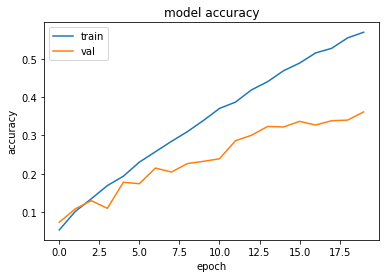

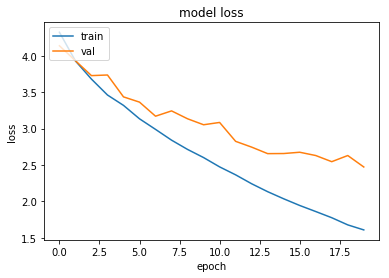

In [11]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
test_X = np.load(open("test_X.npy", 'rb'))
test_y = np.load(open("test_y.npy", 'rb'))

predictions = [np.argmax(model.predict(np.expand_dims(x, axis=0))) for x in test_X]
test_accuracy = 100 * np.sum(np.array(predictions) == test_y) / len(predictions)
print('Test accuracy: %.2f%%' % test_accuracy)

Test accuracy: 36.88%


In [22]:
misclassified = np.nonzero(np.array(predictions) != test_y)[0]

In [61]:
image_index = np.random.choice(misclassified)
print('image_index = %d, prediction = %d, truth_label = %d' % 
      (image_index, predictions[image_index], test_y[image_index]))

image_index = 4869, prediction = 13, truth_label = 63
